# Large Notebook 3: Reinfocement Learning
## Ex. 3: Control problem MountainCar-v0

In the exercise class we will cover the control problem of a car at the bottom of a valley which should pick-up enough momentum to get over the hill. We will use the environment from the OpenAI Gym, which allows you to play and visualize the 'game'. Use RL to train a policy that gets the car over the hill in the least amount of time. 

**Before you can start this exercise you have to install the package OpenAI Gym. Start your anaconda environment with python3 and install:**

* pip install gymnasium[classic-control]


In [5]:
# UNCOMMENT IF GYMNASIUM FAILS TO IMPORT
# %pip install gymnasium[classic-control]

import gymnasium as gym
import numpy as np

If you have properly installed the openAI gym you should be able to import it. We will now run a DEMO to see if everything is working. The code already is able to simulate the MountainCar problem for the case that it actions are **random**. To be able to view the rendered video of the poor and helpless car, desperately trying to drive up the hill, you should run the code on your own computer.
For more info on this particular environment see e.g. the website: https://gymnasium.farama.org/environments/classic_control/mountain_car/



In [48]:
def demo():
    """run the MountainCar environment with random actions"""
    
    env = gym.make('MountainCar-v0', render_mode='human')  #  create an instance of the environment

    state = env.reset()  # reset the current game

    for _ in range(200):  # play 200 random actions
        env.render()  # render the current game state to screen
        a = env.action_space.sample()  # get a random action
        state, reward, terminated, truncated, info = env.step(a) # take the action and return the outcome
        
    env.close()
    
# run the demo
demo() 

## Building your RL player, ie. training your policy.
We have to start by creating the game environment and checking some properties of the state and action space:

In [6]:
env = gym.make('MountainCar-v0')  # no rendering!

# get usefull information about the environment:
state = env.reset()
print('start state:', state)
print('Number of actions in the action space:', env.action_space.n)
print('Lowest state in the state space:', env.observation_space.low)
print('Hightest state in the state space:', env.observation_space.high)

#perform one step of the game for action a=1
a=1
state, reward, terminated, truncated, info = env.step(a)
print('After the step with (a=1):',state, reward, terminated, truncated, info )


start state: (array([-0.5851905,  0.       ], dtype=float32), {})
Number of actions in the action space: 3
Lowest state in the state space: [-1.2  -0.07]
Hightest state in the state space: [0.6  0.07]
After the step with (a=1): [-5.8473116e-01  4.5931363e-04] -1.0 False False {}


We see that the car starts out in state with two floats [-0.525, 0] (as it initializes random these numbers will differ each time you reset). You can perform any of 3 actions (a = 0 or 1 or 2). We don't know what the numbers in the state mean, they could be the $x$, $y$ coordinates of the car or the velocity and height, but **we also don't have to know!** We will let the RL algortithm learn how to drive the car regardless of the exact meaning of the state.

You should now code a function `s2q(s)` that links state `s` to a location in the Q-matrix. This can quickly be done by discretizing the state space into bins and determine the bin number corresponding to a certain value. The function should return a tuple (or list) `loc` that holds the two bin numbers.

In [7]:
def s2q(s):
    # convert continous state values to discrete location indices inside the Q matrix
    bin = 10  
    loc = (s-env.observation_space.low)/(env.observation_space.high - env.observation_space.low)
    loc = np.floor(loc*bin)
    loc = tuple(loc.astype(int))

    return loc

# state = env.reset()
# state = np.array(state[0])
# print(state)
s2q(state)


(np.int64(3), np.int64(5))

The next function `qlearn()` should train your Q-matrix by playing `num_games` games according to an 'epsilon-greedy' strategy (Google it!) and update the Q-matrix accoding to the following Bellmann equation:

$$ \mathbf{Q}^{\rm new}[s_t,a_t]=(1-\alpha)\mathbf{Q}[s_t,a_t]+\alpha\left(R_t+\gamma\, \text{max}_a  \mathbf{Q}[s_{t+1},a]\right). $$

Here, $\alpha$ is the learning rate and $\gamma$ is the discount factor and are bounded by $\alpha,\gamma\in[0,1]$. These parameters have to be set with care, as they influence the speed of convergence of the Q-matrix. The discount factor lets you weigh the importance of future over immediate rewards. This is done by mixing-in the term $\text{max}_a  \mathbf{Q}[s_{t+1},a]$, which gives the maximum Q value in the future state.

In [8]:
def qLearn(Q, α, γ, ϵ, ϵ_min, num_games):
    """ 
    learns the Q table by interacting with the environment and applying the Bellman equation 
    Q: q-table (n-dimensional ndarray)
    α: learning rate
    γ: discount factor
    ϵ: probability of taking a random action in the epsilon-greedy policy
    ϵ_min: minimum value ϵ can take when applying a reduction algortihm to ϵ
    """
    
    # initialize Q
    # Q = np.random.rand(s2q(env.observation_space.high), env.action_space.n)
    wins = 0
    
    decay_rate = 0.9
    
    for n in range(num_games):
        state = env.reset()  # reset the current game
        state = np.array(state[0])
        ϵ = np.max((ϵ_min, ϵ*decay_rate))
        # print('Game n.:', n)
        for _ in range(200):
            if np.random.rand() < ϵ:
                a = env.action_space.sample()
            else:
                a = np.argmax(Q[s2q(state)])
            state_new, reward, terminated, truncated, info = env.step(a)
            Q[s2q(state)[0], s2q(state)[1],a] = (1-α)*Q[s2q(state)[0], s2q(state)[1],a] + α*(reward+γ*np.max(Q[s2q(state_new)]))
            # print('After a step:',state_new, reward, terminated, truncated, info )
            state = state_new
            if (terminated == True):
                wins += 1
                break

    print(f'Training ended. Number of wins: {wins} out of {num_games} games')
    return wins/num_games

Finally you put everything together. It is almost completly finished for you. What values for the hyperparameters do you choose? 

In [9]:
# initialize the Q matrix as a numpy array with zeros
Q = np.zeros(shape=(*s2q(env.observation_space.high), env.action_space.n))
# print(Q.shape)

# set the hyperparameters
α = 0.2  # learning rate [0,1]
γ = 0.99  # discount rate [0,1]
ϵ = 0.8  # epsilon greedy strategy [0,1]
ϵ_min = 0.01  # minimum value of epsilon [0,1]
num_games = 1000 # number of training games

# train the agent and store results
qLearn(Q, α, γ, ϵ, ϵ_min, num_games)
# print(Q)
np.save('qrun1.npy', Q)


Training ended. Number of wins: 284 out of 1000 games


Once a Q-matrix has been trained we can use it as a policy and play a game. Write code that performs actions according to the input Q-matrix to play a single episode.

In [10]:
# replay the game using the trained Q matrix
Q = np.load('qrun1.npy')

# create and reset the environment with render mode on
env = gym.make('MountainCar-v0', render_mode='human')
state = env.reset()
state = np.array(state[0])
    
# play a single episode with max. 1000 actions
for _ in range(1000):           
    env.render()                
    loc = s2q(state)
    a = np.argmax(Q[loc]) 
    state, reward, terminated, truncated, info = env.step(a) 
        
    if terminated: 
        print('Qplay Output:', reward, terminated, truncated, info)
        break

env.close()

Qplay Output: -1.0 True True {}


# Experiments
Set up a couple fo experiments to figure out the following things:
* How do $\alpha$ and $\gamma$ effect your learning perfomance?
* Are both elements of the state vector equally important and can we reduce the dimensions of the Q-matrix of one (or both) of them?

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

env = gym.make('MountainCar-v0')  # no rendering!

# set the hyperparameters
α = np.linspace(0.2, 0.9, 5)  # learning rate [0,1]
α = np.linspace(0.2, 0.9, 5)  # discount rate [0,1]
ϵ = 0.8  # epsilon greedy strategy [0,1]
ϵ_min = 0.01  # minimum value of epsilon [0,1]
num_games = 1000 # number of training games

performance = np.zeros(shape=(len(α), len(γ)))

# train the agent and store results
for i, alpha in enumerate(α):
    for j, gamma in enumerate(γ):
        Q = np.zeros(shape=(*s2q(env.observation_space.high), env.action_space.n))
        print('α =', alpha, ', γ =', gamma)
        performance[i, j] = qLearn(Q, alpha, gamma, ϵ, ϵ_min, num_games)


α = 0.2 , γ = 0.3
Training ended. Number of wins: 69 out of 1000 games
α = 0.2 , γ = 0.475
Training ended. Number of wins: 75 out of 1000 games
α = 0.2 , γ = 0.6499999999999999
Training ended. Number of wins: 19 out of 1000 games
α = 0.2 , γ = 0.825
Training ended. Number of wins: 151 out of 1000 games
α = 0.2 , γ = 1.0
Training ended. Number of wins: 336 out of 1000 games
α = 0.375 , γ = 0.3
Training ended. Number of wins: 24 out of 1000 games
α = 0.375 , γ = 0.475
Training ended. Number of wins: 88 out of 1000 games
α = 0.375 , γ = 0.6499999999999999
Training ended. Number of wins: 85 out of 1000 games
α = 0.375 , γ = 0.825
Training ended. Number of wins: 99 out of 1000 games
α = 0.375 , γ = 1.0
Training ended. Number of wins: 181 out of 1000 games
α = 0.55 , γ = 0.3
Training ended. Number of wins: 4 out of 1000 games
α = 0.55 , γ = 0.475
Training ended. Number of wins: 0 out of 1000 games
α = 0.55 , γ = 0.6499999999999999
Training ended. Number of wins: 31 out of 1000 games
α = 0.55

[[0.069 0.075 0.019 0.151 0.336]
 [0.024 0.088 0.085 0.099 0.181]
 [0.004 0.    0.031 0.034 0.221]
 [0.009 0.008 0.006 0.054 0.143]
 [0.001 0.034 0.012 0.018 0.04 ]]


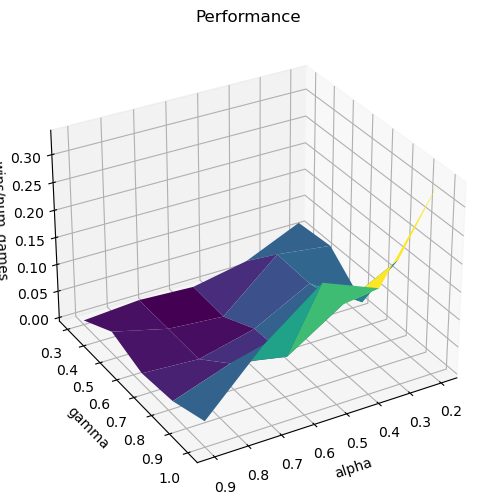

In [60]:
α1, γ1 = np.meshgrid(α, γ)
print(performance)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(α1, γ1, performance.T, cmap='viridis')
ax.view_init(elev=30, azim=60)

ax.set_xlabel('alpha')
ax.set_ylabel('gamma')
ax.set_zlabel('wins/num_games')
ax.set_title('Performance')

plt.show()

We choose the optimal values of α and γ based on the number of wins achieved during a 1000-games training, we select α = 0.2 and γ = 1.0.

In [66]:
def s2q2(s, bin_x, bin_y):
    # convert continous state values to discrete location indices inside the Q matrix
    loc = np.zeros(2)
    loc[0] = (s[0]-env.observation_space.low[0])/(env.observation_space.high[0] - env.observation_space.low[0])
    loc[0] = np.floor(loc[0]*bin_x)
    loc[1] = (s[1]-env.observation_space.low[1])/(env.observation_space.high[1] - env.observation_space.low[1])
    loc[1] = np.floor(loc[1]*bin_y)
    loc = tuple(loc.astype(int))

    return loc

s2q2(state, 10, 10)

(9, 6)

In [67]:
def qLearn(Q, bin_x, bin_y, α, γ, ϵ, ϵ_min, num_games):
    """ 
    learns the Q table by interacting with the environment and applying the Bellman equation 
    Q: q-table (n-dimensional ndarray)
    α: learning rate
    γ: discount factor
    ϵ: probability of taking a random action in the epsilon-greedy policy
    ϵ_min: minimum value ϵ can take when applying a reduction algortihm to ϵ
    """
    
    # initialize Q
    # Q = np.random.rand(s2q(env.observation_space.high), env.action_space.n)
    wins = 0
    
    decay_rate = 0.9
    
    for n in range(num_games):
        state = env.reset()  # reset the current game
        state = np.array(state[0])
        ϵ = np.max((ϵ_min, ϵ*decay_rate))
        # print('Game n.:', n)
        for _ in range(200):
            if np.random.rand() < ϵ:
                a = env.action_space.sample()
            else:
                a = np.argmax(Q[s2q2(state, bin_x, bin_y)])
            state_new, reward, terminated, truncated, info = env.step(a)
            Q[s2q2(state, bin_x, bin_y)[0], s2q2(state, bin_x, bin_y)[1],a] = (1-α)*Q[s2q2(state, bin_x, bin_y)[0], s2q2(state, bin_x, bin_y)[1],a] + α*(reward+γ*np.max(Q[s2q2(state_new, bin_x, bin_y)]))
            # print('After a step:',state_new, reward, terminated, truncated, info )
            state = state_new
            if (terminated == True):
                wins += 1
                break

    print(f'Training ended. Number of wins: {wins} out of {num_games} games')
    return wins/num_games

In [69]:
optimal_alpha = 0.2
optimal_gamma = 1
ϵ = 0.8  # epsilon greedy strategy [0,1]
ϵ_min = 0.01  # minimum value of epsilon [0,1]
num_games = 1000 # number of training games

bin_x = np.linspace(2, 18, 5)
bin_y = np.linspace(2, 18, 5)

performancebxby = np.zeros(shape=(len(bin_x), len(bin_y)))

# train the agent and store results
for i, bx in enumerate(bin_x):
    for j, by in enumerate(bin_y):
        Q = np.zeros(shape=(*s2q2(env.observation_space.high, bx, by), env.action_space.n))
        print('bin_x =', bx, ', bin_y =', by)
        performancebxby[i, j] = qLearn(Q, bx, by, optimal_alpha, optimal_gamma, ϵ, ϵ_min, num_games)

bin_x = 2.0 , bin_y = 2.0
Training ended. Number of wins: 0 out of 1000 games
bin_x = 2.0 , bin_y = 6.0
Training ended. Number of wins: 0 out of 1000 games
bin_x = 2.0 , bin_y = 10.0
Training ended. Number of wins: 0 out of 1000 games
bin_x = 2.0 , bin_y = 14.0
Training ended. Number of wins: 77 out of 1000 games
bin_x = 2.0 , bin_y = 18.0
Training ended. Number of wins: 52 out of 1000 games
bin_x = 6.0 , bin_y = 2.0
Training ended. Number of wins: 197 out of 1000 games
bin_x = 6.0 , bin_y = 6.0
Training ended. Number of wins: 220 out of 1000 games
bin_x = 6.0 , bin_y = 10.0
Training ended. Number of wins: 208 out of 1000 games
bin_x = 6.0 , bin_y = 14.0
Training ended. Number of wins: 176 out of 1000 games
bin_x = 6.0 , bin_y = 18.0
Training ended. Number of wins: 123 out of 1000 games
bin_x = 10.0 , bin_y = 2.0
Training ended. Number of wins: 278 out of 1000 games
bin_x = 10.0 , bin_y = 6.0
Training ended. Number of wins: 376 out of 1000 games
bin_x = 10.0 , bin_y = 10.0
Training end

[[0.    0.    0.    0.077 0.052]
 [0.197 0.22  0.208 0.176 0.123]
 [0.278 0.376 0.418 0.335 0.266]
 [0.255 0.315 0.423 0.238 0.162]
 [0.263 0.31  0.311 0.204 0.121]]


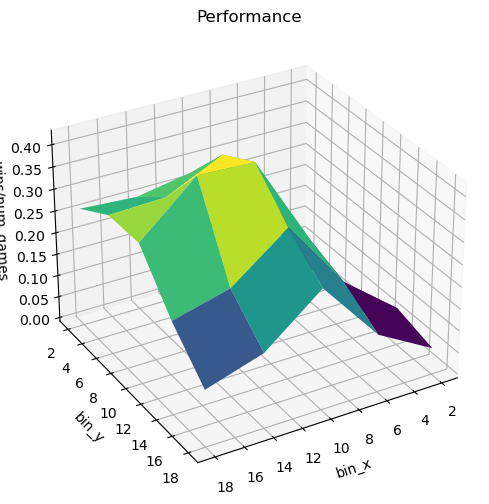

In [74]:
bin_x1, bin_y1 = np.meshgrid(bin_x, bin_y)
print(performancebxby)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(bin_x1, bin_y1, performancebxby.T, cmap='viridis')
ax.view_init(elev=30, azim=60)

ax.set_xlabel('bin_x')
ax.set_ylabel('bin_y')
ax.set_zlabel('wins/num_games')
ax.set_title('Performance')

plt.show()

We can reduce substantially the dimension of the Q-matrix with respect to the second element of the state vector, even using 2 bins. Conversely, the first element is more important and must be described with more accuracy, i.e. more bins (at least 10).